<a href="https://colab.research.google.com/github/ArturSidorenko/Fourier-transform-2D-for-functions-satisfying-specific-conditions/blob/master/summerschool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<style>
    ul {list-style-position: inside; padding-left:0; margin-top:0;}
    p.a {margin-bottom:0; margin-top:0}
</style>
# Быстрые вычисления на Python с применениями в финансовой математике

**Летняя школа Вега 2022**  
*Лектор: Михаил Житлухин*

**Содержание курса**  

<p class="a">В этом мини-курсе будет дан обзор пакетов Python для быстрых вычислений:</p>

- NumPy – операции с массивами;
- Numba – динамическая компиляция кода;
- CuPy – вычисления на GPU.

<p class="a">В качестве примеров мы реализуем</p>

- метод Монте-Карло для оценки опционов в модели Хестона;
- метод подгонки параметров модели Хестона по наблюдаемым ценам опционов.

# 1. Введение
## 1.1. Модель Блэка-Шоулса и предполагаемая волатильность
В модели Блэка-Шоулса цена акции задается геометрическим броуновским движением:
$$d S_t = \mu S_t dt + \sigma S_t d W_t, \qquad S_0 = s>0.$$
Цену опциона колл можно вычислить как ожидание по эквивалентной мартингальной мере $Q$:
$$C = e^{-rT} E^Q(S_T-K)^+,$$
где $r$ – безрисковая процентная ставка, а цена акции относительно $Q$ удовлетворяет уравнению
$$d S_t = r S_t dt + \sigma S_t d W_t, \qquad S_0 = s>0.$$

**Теорема (формула Блэка-Шоулса)**. Безарбитражная цена опциона колл с временем исполнения $T$ и страйком $K$ равна
$$C = s\Phi(d_1) + e^{-rT} K\Phi(d_2),$$
где
$$
d_1 = \frac{1}{\sigma\sqrt T}\left(\ln\frac sK + \left(r+\frac{\sigma^2}2\right)T\right), \qquad
d_2 = d_1 - \sigma\sqrt{T}.
$$

**Определение.** *Предполагаемой волатильностью* $\sigma(T,K)$ называется значение $\sigma$ для которого цена опциона с временем исполнения $T$ и страйком $K$, вычисленная по формуле Блэка-Шоулса, совпадает с его рыночной ценой.

Эмпирический факт: опционы с различными $T,K$ имеют различные предполагаемые волатильности. 

## 1.2. Модель Хестона

**Определение.** *Модель Хестона* задается уравнениями (относительно мартингальной меры)
$$
\begin{aligned}
&d S_t = r S_t dt + \sqrt{V_t} S_t d W_t^1, \qquad S_0=s>0,\\
& d V_t = \kappa(\theta-V_t) dt + \sigma \sqrt{V_t} d W_t^2,\qquad V_0=v>0, \\
& d W_t^1 d W_t^2 = \rho dt,
\end{aligned}
$$
где $\kappa>0$, $\theta>0$, $\sigma>0$, $\rho\in(-1,1)$ – параметры модели.

*Замечание.* Данная система уравнений имеет единственное (сильное) решение, причем процесс $S_t$ строго положителен, а процесс $V_t$ неотрицателен.

## 1.3. Вычисление цен опционов методом Монте-Карло

Пусть необходимо вычислить математическое ожидание $E(X)$ для некоторой случайной величины $X$. Если имеется алгоритм симуляции случайных значений $x_1,\ldots,x_n,$ то положим
$$E(X) \approx \bar x := \frac1n \sum_{i=1}^n x_i.$$
Доверительный интервал вероятности $p$ для данной оценки
$$E(X) \in [\bar x - \varepsilon, \bar x + \varepsilon], \qquad \varepsilon= z \frac{s_x}{\sqrt{n}},$$
где $z$ – критическое значение, соответствующее вероятности $p$ (например, $z=1.96$ для $p=0.95$) и $s_x^2$ – выборочная дисперсия
$$s_x^2 = \frac{1}{n-1}\sum_{i=1}^n (x_i-\bar x)^2.$$

## 1.4. Схема Эйлера для симуляции модели Хестона

 *Схема Эйлера* - это универсальный и простой метод симуляции решений стохастических дифференциальных уравнений. Применительно к модели Хестона она выглядит следующим образом.
 



Если нужно получить реализации процессов $V_t$ и $X_t=\ln(S_t)$ в моменты времени $t_i=i\Delta t$, то положим
$$
\begin{aligned}
&V_{t_{i+1}} = V_{t_i} + \kappa(\theta-V_{t_i}^+) \Delta t + \sigma \sqrt{V_{t_i}^+} Z_{i+1}^1\sqrt{\Delta t},\\
&X_{t_{i+1}} = X_{t_i} + (r-\frac12 V_{t_i}^+)\Delta t + \sqrt{V_{t_i}^+} S_{t_i} (\rho Z_{i+1}^1 + \sqrt{1-\rho^2} Z_{i+1}^2)\sqrt{\Delta t},\\
\end{aligned}
$$
где $Z_i^1$ и $Z_i^2$ являются последовательностями н.о.р. стандартных нормальных величин. 

*Замечание.* Приведенная формула для $X_t$ получается из применения формулы Ито к процессу $S_t$ и замены $V_{t_i}$ на $V_{t_i}^+$ (чтобы избежать отрицательных значений под корнем). Для получения значений $S_t$ положим $S_{t_i} = \exp(X_{t_i})$.

## 1.5. Реализация метода Монте-Карло на Python (медленно)
### 1.5.1. Код

In [ ]:
from dataclasses import dataclass
import math
import random as rnd
from scipy import stats as st
import matplotlib.pyplot as plt

In [ ]:
# @dataclass is a convenient construction to avoid writing 
# __init__ and other standard methods
@dataclass
class HestonParams:
    """Parameters of the Heston model.
    
    Attributes:
      s: Stock price at time 0.
      v: Variance at time 0.
      kappa, theta, sigma, rho: 
        Corresponding parameters of the model.
        
    Notes:
      The risk-free interest rate is assumed to be 0.
    """
    s: float
    v: float
    kappa: float
    theta: float
    sigma: float
    rho: float

        
@dataclass
class MCResult:
    """Results of Monte-Carlo simulation.
    
    Attributes:
      x: Mean of random variates (the estimate of the sought-for value).
      error: Margin of error (half of the confidence interval).
      paths: Number of simulated paths.
    """
    x: float
    error: float    
    paths: int

        
def monte_carlo(simulator, f, error = 1e-3, conf_level = 0.95, max_paths = 1000000):
    """Estimates the expectation of a random variable by the Monte-Carlo method.

    This function computes the expected value `E(f(X))`, where `f` is the
    provided function and `X` is a random element which is simulated by
    calling `simulator`. The value of `X` need not be a scalar. For example, 
    `X` can be an array or list representing a path of a random process.

    Args:
      simulator: Function which produces random realizations.
      f: Function which is applied to the random realizations. 
      error: Desired margin of error.
      conf_level: Confidence level.
      max_paths: Maximum number of paths to simulate. The desired margin of 
        error may be not reached if more than `max_paths` paths are required.

    Returns:
      An `MCResult` structure with simulation results.
    """
    z = st.norm.ppf((1+conf_level)/2)
    x = 0      # estimate of `E(f(X))`
    x_sq = 0   # estimate of `E(f(X)^2)`
    s = 0      # standard error of x
    n = 0      # paths counter
    while (n < 10 or (z*s/math.sqrt(n) > error and n < max_paths)):
        y = f(simulator())
        x = (x*n + y)/(n+1)                 
        x_sq = (x_sq*n + y**2) / (n+1)      
        s = math.sqrt(x_sq - x**2)  
        n += 1       
    
    return MCResult(x, z*s/math.sqrt(n), n)


def heston_euler(h, t, steps):
    """Simulation of the price process in the Heston model by Euler's scheme.
    
    Args:
      h: Model parameters (HestonParams).
      t: Time horizon.
      steps: Number of simulation steps.
      
    Returns:
      A list of length `steps+1` with simulated values of one path of the process 
      at points `t_i = i*t/n`, where `i=0,1,...,steps`.
    """
    dt = t/steps
    S = [h.s]
    V = [h.v]
        
    for i in range(steps):
        v_plus = max(V[i], 0)
        Z1 = rnd.gauss(0, 1)
        Z2 = rnd.gauss(0, 1)
        V.append(V[-1] + h.kappa*(h.theta-v_plus)*dt + h.sigma*math.sqrt(v_plus) * Z1*math.sqrt(dt))
        S.append(S[-1] * math.exp(
            -0.5*v_plus*dt + math.sqrt(v_plus)*(h.rho*Z1 + math.sqrt(1-h.rho**2)*Z2)*math.sqrt(dt)))
    
    return S

### 1.5.2. Примеры
Во всех примерах далее будут использоваться следующие значения параметров модели Хестона
$$
s = 1, \quad v=0.2, \quad \kappa=1, \quad \theta=0.2, \quad \sigma=0.4, \quad \rho=-0.1.
$$
Будем рассматривать опцион колл с временем исполнения $T=\frac 12$ и количеством точек $n=125$ в разбиении отрезка $[0,\frac12]$ (что соответствует $\frac12$ года и 125 торговым дням за этот промежуток).

In [ ]:
# Parameters of the Heston model used below
h = HestonParams(s=1, v=0.2, kappa=1, theta=0.2, sigma=0.4, rho=-0.1)
t = 0.5
steps = 125

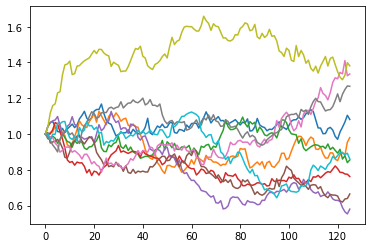

In [ ]:
# Example 1: simulation of random paths
for i in range(10):
    plt.plot(heston_euler(h, t, steps))

In [ ]:
#### Example 2: Computation of a call option price
k = 1.1
%time res = monte_carlo(lambda: heston_euler(h, t, steps), lambda s: max(s[-1] - k, 0), max_paths=5000)
print("-----")
print(res)

# Remark: the maximum number of paths is limited to 5000 to save time. 
# Here, to achieve error=1e-3, approximately 140000 paths are required. 

CPU times: user 1.93 s, sys: 3.13 ms, total: 1.94 s
Wall time: 1.94 s
-----
MCResult(x=0.09094798992042519, error=0.005656441324589171, paths=5000)


# 2. NumPy: быстрые операции с массивами

В стандартном Python для работы с массивами нужно использовать списки. Например, `x = [[1, 0], [0, 1]]` задает единичную матрицу 2x2. Недостатки: неудобно и медленно.

**NumPy** (**Num**erical **Py**thon) - это пакет для быстрых операций с массивами, линейной алгебры, преобразований Фурье, и других алгоритмов. 

In [ ]:
import numpy as np

## 2.1. Краткое введение в NumPy на примерах
### 2.1.1. Создание массивов

In [ ]:
# Creation of an array from a list
x = np.array([1, 2, 5, 10])
print("x =\n", x)

# Creation of a 2-dimensional array
# (multidimensional arrays are created in a similar way)
y = np.array([[1,0], [0,1], [1,1]])
print("y =\n", y)

# An array has dimensions, shape (lengths of each dimension), size (total number of elements)
print("x: dimensions", x.ndim, "| shape", x.shape, "| size", x.size)
print("y: dimensions", y.ndim, "| shape", y.shape, "| size", y.size)

x =
 [ 1  2  5 10]
y =
 [[1 0]
 [0 1]
 [1 1]]
x: dimensions 1 | shape (4,) | size 4
y: dimensions 2 | shape (3, 2) | size 6


In [ ]:
# Creation of some simple arrays of a given shape
x = np.zeros(shape=5)
y = np.ones(shape=(3,2))

# Empty arrays are useful to pre-allocate memory
# (but when created, they contain garbage data)
z = np.empty(shape=(2,2))

# `np.arange(start, stop, step)` is similar to Python's `range`
# and returns the array [start, start+step, start+2*step, ..., stop)
u = np.arange(0,10, 2) 

# `np.linspace(a, b, n)` divides [a, b] into n-1 equal intervals
v = np.linspace(0,1,11)

print("x =\n", x, "\ny =\n", y, "\nz =\n", z, "\nu =\n", u, "\nv =\n", v)

x =
 [0. 0. 0. 0. 0.] 
y =
 [[1. 1.]
 [1. 1.]
 [1. 1.]] 
z =
 [[4.9e-324 9.9e-324]
 [2.5e-323 4.9e-323]] 
u =
 [0 2 4 6 8] 
v =
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


### 2.1.2. Массивы случайных чисел

In [ ]:
# For the standard normal distribution use np.random.randn
# or `np.random.standard_normal` 
# The argument `size` is the shape of the generated array
x = np.random.standard_normal(size=5)
y = np.random.standard_normal(size=(2,2))
print("x =\n", x, "\ny =\n", y)

# For the uniform distribution on [0, 1), use `np.random.random` 
# or `np.random.random_sample`
z = np.random.random_sample(size=3)
print("z =\n", z)

x =
 [0.30937355 0.08134426 2.16389529 1.02247086 1.20839302] 
y =
 [[ 1.5573663  -0.62830058]
 [ 0.82393437 -0.80423728]]
z =
 [0.06981671 0.52125511 0.48779617]


### 2.1.3. Доступ к элементам массива

In [ ]:
# For a 1-dimensional array use x[i]
# Note: indices start from 0.
# Negative indices count from the end (-1 is the last element).
x = np.linspace(0, 1, 11)
print("x =\n", x)
print("x[5] = ", x[5])
print("x[-1] = ", x[-1])
print("-----")

# For a 2-dimensional array use y[i,j]; while y[i] returns the i-th row.
# Similarly for N-dimensional arrays.
y = np.random.standard_normal((3,3))
print("y =\n", y)
print("y[1,1] =", y[1,1])
print("y[1] =", y[1])
print("-----")


x =
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
x[5] =  0.5
x[-1] =  1.0
-----
y =
 [[-1.28343728  1.65783472  0.75771949]
 [-0.96880011 -1.13793366 -2.55108533]
 [ 3.38885817 -0.2466123  -1.59687963]]
y[1,1] = -1.1379336565109615
y[1] = [-0.96880011 -1.13793366 -2.55108533]
-----


### 2.1.4. Срезы

In [ ]:
# To get elements between i-th (inclusively) and j-th (exclusively) positions, use
# x[i:j]
x = np.linspace(0, 1, 11)
print("x =\n", x)
print("x[1:5] =", x[1:5])

# In particular, x[i:] are all elements starting from the i-th one (including it)
# x[:j] are all elements up to the j-th one (not including it)
print("x[:5] =", x[:5])

# To get each n-th element between i-th and j-th positions, use
# x[i:j:n]
# In particular, x[i:j] is the same as x[i:j:1] 
print("x[2:6:2] =", x[2:6:2])
print("-----")

# Similar rules apply to multidimensional arrays
y = np.random.standard_normal((3,3))
print("y =\n", y)
print("y[:,1] =", y[:,1])    # column 1
print("y[1:,0] =", y[1:,0])  # elements 1,2 from column 0

x =
 [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
x[1:5] = [0.1 0.2 0.3 0.4]
x[:5] = [0.  0.1 0.2 0.3 0.4]
x[2:6:2] = [0.2 0.4]
-----
y =
 [[-0.10073619 -0.33252863 -0.15735338]
 [ 0.94588951 -0.86316328 -0.14757849]
 [-0.47302901  0.37963475 -2.18095789]]
y[:,1] = [-0.33252863 -0.86316328  0.37963475]
y[1:,0] = [ 0.94588951 -0.47302901]


### 2.1.5. Базовые операции

In [ ]:
# Arithmetic operations are performed elementwise
x = np.array([1,2,3])
y = np.array([10,20,30])
print("x =", x, "\ny =", y)
print("x + y =", x + y, "\nx * (y+1) =", x*(y+1))

# For scalar product and matrix multiplication, use np.dot
print("(x,y) =", np.dot(x,y))


x = [1 2 3] 
y = [10 20 30]
x + y = [11 22 33] 
x * (y+1) = [11 42 93]
(x,y) = 140


In [ ]:
# Some common functions 
x = np.linspace(0, 10, 11)
print("x =", x)

print("sum =", np.sum(x)) # sum of all elements
print("mean =", np.mean(x), "\nvariance =", np.var(x), "\nstd. dev. =", np.std(x)) # mean, variance, std. dev.
# note: if x represents a sample, use `np.var(x, ddof=1)` to get an unbiased estimate. Same for np.std
print("||x|| =", np.linalg.norm(x))  # L2 (Euclidean) norm
print("-----")

# Functions that return arrays
print("cumulative sum =", np.cumsum(x))  # cumulative (accumulating) sum
print("difference =", np.diff(x))  # difference of x[i+1]-x[i] for i=0, ..., x.size-1

x = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
sum = 55.0
mean = 5.0 
variance = 10.0 
std. dev. = 3.1622776601683795
||x|| = 19.621416870348583
-----
cumulative sum = [ 0.  1.  3.  6. 10. 15. 21. 28. 36. 45. 55.]
difference = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### 2.1.6. Универсальные функции

In [ ]:
# A universal function (ufunc) in NumPy is a function that is applied 
# to each element of an array and returns an array.
# Many standard mathematical function in NumPy are made universal.
x = np.linspace(0, 1, 6)
print("x =", x)
print("sin(x) =", np.sin(x))
print("log(exp(x)) =", np.log(np.exp(x)))   # we'll get just x

x = [0.  0.2 0.4 0.6 0.8 1. ]
sin(x) = [0.         0.19866933 0.38941834 0.56464247 0.71735609 0.84147098]
log(exp(x)) = [0.  0.2 0.4 0.6 0.8 1. ]


### 2.1.7. Построение графиков

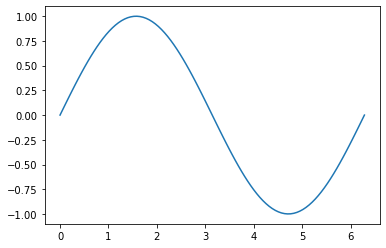

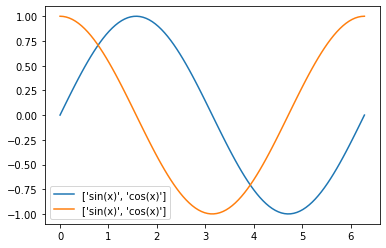

In [ ]:
# Use matplotlib.pyplot.plot(x, y) to plot an array y as a function of x,
# i.e. to draw a piecewise linear function through the points (x_i, y_i).
x = np.linspace(0, 2*np.pi, 100)
plt.plot(x, np.sin(x))
plt.show()

# If y is a 2-dimensional array with shape (n,m), where n==x.size, then
# plt.plot(x,y) plots m functions corresponding to y's columns.
plt.plot(x, np.transpose([np.sin(x), np.cos(x)]), label=["sin(x)", "cos(x)"])
plt.legend()
plt.show()

## 2.2. Использование NumPy для метода Монте-Карло
Мы будем симулировать траектории группами по `batch_size` траекторий в группе и добавим соответствующий параметр в функцию `monte_carlo`.

### 2.2.1. Код

In [ ]:
def monte_carlo(simulator, f, error=1e-3, conf_level=0.95, max_paths=10000000, 
                batch_size=10000):
    """Estimates expectation of a random variable by the Monte-Carlo method.

    This function computes the expected value `E(f(X))`, where `f` is the
    provided function and `X` is a random element which is simulated by
    calling `simulator`. 

    Args:
      simulator: Function which produces random realizations. It must be of the
        form `simulator(n)`, where `n` is the number of realizations to produce
        (it will be called with `n=batch_size`). For example, when simulating
        a random process, `simulator(n)` can return an array of shape `(n,d)`,
        where `n` is the number of paths, and `d` is the number of points in
        each path.
      f: Function to apply to the random realizations. It must accept a whole 
        batch of realizations and return an array which contains the results of
        applying the function to each realization in the batch, i.e. when called
        as `f(simulator(n))`, it must return an array of length `n`.
      error: Desired margin of error.
      conf_level: Confidence level.
      max_paths: Maximum number of paths to simulate. The desired margin of
        error may be not reached if more than `max_paths` paths are required.
      batch_size: The size of one batch.

     Returns:
      An `MCResult` structure with simulation results.
    """
    z = st.norm.ppf((1+conf_level)/2)
    x = 0      # estimate of `E(f(X))`
    x_sq = 0   # estimate of `E(f(X)^2)`
    s = 0      # standard error of x
    n = 0      # batches counter (number of paths = n*batch_size)    
    
    while (n==0 or (z*s/math.sqrt(n*batch_size) > error and n*batch_size < max_paths)):
        y = f(simulator(batch_size))
        x = (x*n + np.mean(y))/(n+1)
        x_sq = (x_sq*n + np.mean(y**2)) / (n+1)
        s = math.sqrt(x_sq - x**2) 
        n += 1
    
    return MCResult(x, z*s/math.sqrt(n*batch_size), n*batch_size)
    
    # Remark: in the above function, we could also apply np.sqrt to scalars
    # (e.g. np.sqrt(n*batch_size)). This would give the same result, but would be slower.


def heston_euler(paths, h, t, steps):
    """Simulation of the price process in the Heston model by Euler's scheme.
    
    Args:
      paths: Number of paths to simulate.
      h: Model parameters.
      t: Time horizon.
      steps: Number of simulation steps.
      
    Returns:
      An array of shape `(steps+1, paths)` with simulated paths at points
      `t_i = i*t/n`, where `i=0,1,...,steps`.
    """
    dt = t/steps
    S = np.empty((steps+1, paths))   # S[i,j] is the value of the j-th path at time t_i
    V = np.empty((steps+1, paths))   # same for V[i,j]
    S[0] = h.s
    V[0] = h.v
    Z = np.random.randn(2, steps, paths)
    
    for i in range(steps):
        v_plus = np.maximum(V[i], 0)
        V[i+1] = V[i] + h.kappa*(h.theta-v_plus)*dt + h.sigma*np.sqrt(v_plus) * Z[0,i]*math.sqrt(dt)
        S[i+1] = S[i] * np.exp(
            -0.5*v_plus*dt + np.sqrt(v_plus)*(h.rho*Z[0,i] + math.sqrt(1-h.rho**2)*Z[1,i])*math.sqrt(dt))
    
    return S

### 2.2.2. Примеры

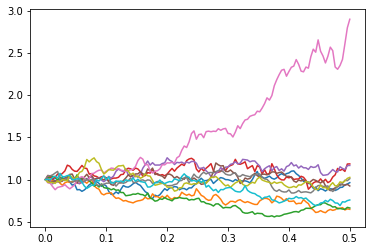

In [ ]:
# Plot several paths just to check the function works correctly
plt.plot(np.linspace(0, 0.5, steps+1), heston_euler(10, h, t, steps));

In [ ]:
%time res = monte_carlo(lambda paths: heston_euler(paths, h, t, steps), lambda s: np.maximum(s[-1] - k, 0))
print(res)

CPU times: user 2.27 s, sys: 19.5 ms, total: 2.29 s
Wall time: 2.43 s
MCResult(x=0.08561431899497338, error=0.0009945385800200395, paths=140000)


## 2.3. Добавление контрольной функции

Чтобы уменьшить дисперсию $f(X)$ и, следовательно, уменьшить число симуляций, необходимых для достижения заданной точности, можно симулировать величину $f(X) - \theta Y$, где $Y$ является случайной величиной с нулевым ожиданием. Обычно, $Y=g(X)$ для некоторой удачно выбранной функции $g(x)$. Такая величина $Y$ называется *контрольной функцией* или *контрольной величиной* (control variate).

Коэффициент $\theta$ нужно выбрать оптимальным образом. Наименьшая дисперсия $f(X) - \theta Y$ достигается при $\theta = \mathrm{cov}(X,Y)/\mathrm{D}(Y)$. Дисперсию $\mathrm{D}(Y)$ можно оценить также методом Монте-Карло, но с малым числом симуляций.

### 2.3.1. Код

In [ ]:
@dataclass
class MCResult:
    """Results of Monte-Carlo simulation.
    
    Attributes:
      x: Mean of random variates (the estimate of the sought-for value).
      error: Margin of error (half of the confidence interval).
      paths: Number of simulated paths.
      control_var_coef: An estimate of the control variate coefficient `theta`.
    """
    x: float
    error: float    
    paths: int    
    control_var_coef: float = None   # `theta` coefficient
        
 
def monte_carlo(simulator, f, error=1e-3, conf_level=0.95, max_paths=10000000, 
                batch_size=10000, control_f=None, control_estimation_paths=5000):
    """Estimates expectation of a random variable by the Monte-Carlo method.

    This function computes the expected value `E(f(X))`, where `f` is the
    provided function and `X` is a random element which is simulated by
    calling `simulator`. 
    
    A control variate can be added: if `control_f` is not None, then we simulate
    `f(X) - theta*control_f(X)`, where the optimal coefficient `theta` is 
    estimated from a simulation of `control_estimation_paths` paths. The random 
    variable `control_f(X)` must have zero expectation.

    Args:
      simulator: Function which produces random realizations. It must be of the 
        form `simulator(n)`, where `n` is the number of realizations to produce 
        (it will be called with `n=batch_size` or `n=control_estimation_paths`). 
        For example, when simulating a random process, `simulator(n)` can 
        return an array of shape `(n,d)`, where `n` is the number of paths, and 
        `d` is the number of points in each path.
      f: Function to apply to the random realizations. It must accept a whole 
        batch of realizations and return an array which contains results of
        applying the function to each realization in the batch, i.e. when called 
        as `f(simulator(n))`, it must return an array of length `n`.
      error: Desired margin of error.
      conf_level: Confidence level.
      max_paths: Maximum number of paths to simulate (to avoid too long 
        simulation time). The desired margin of error may be not reached
        if more than `max_paths` paths are required.
      batch_size: The size of one batch.
      control_f: Function applied to random realizations to obtain a control variate. 
        Must satisfy the same requirements as `f`.
      control_estimation_paths: Number of paths to simulate for the estimation
        of the control variate coefficient.

     Returns:
      An `MCResult` structure with simulation results.
    """
    z = st.norm.ppf((1+conf_level)/2)
    x = 0          # estimate of `E(f(X))`
    x_sq = 0       # estimate of `E(f(X)^2)`
    s = 0          # standard error of x
    n = 0          # batches counter (number of paths = n*batch_size)  
    theta = None   # control variate coefficient
    
    if control_f is not None:
        S = simulator(control_estimation_paths)
        c = np.cov(f(S), control_f(S))    # c is the covariance matrix for the two random variables
        theta = c[0, 1] / c[1, 1]
    
    while (n==0 or (z*s/math.sqrt(n*batch_size) > error and n*batch_size < max_paths)):
        S = simulator(batch_size)
        if control_f is not None:
            y = f(S) - theta*control_f(S)
        else:
            y = f(S) 
        x = (x*n + np.mean(y))/(n+1)
        x_sq = (x_sq*n + np.mean(y**2)) / (n+1)
        s = math.sqrt(x_sq - x**2) 
        n += 1
    
    return MCResult(x, z*s/math.sqrt(n*batch_size), n*batch_size, theta)    

### 2.3.2. Пример

In [ ]:
%time res = monte_carlo(lambda paths: heston_euler(paths, h, t, steps), lambda s: np.maximum(s[-1] - 1.1, 0), control_f = lambda s: s[-1] - 1)
print(res)

CPU times: user 715 ms, sys: 8.85 ms, total: 724 ms
Wall time: 725 ms
MCResult(x=0.08581004915186433, error=0.0009884132848409842, paths=40000, control_var_coef=0.5079128795803143)


### 2.3.3. Сравнение скорости с C++

Программа `mc.cpp` делает те же самые вычисления на C++ (но с некоторыми упрощениями; например, число траекторий фиксировано в 40000, не используется контрольная функция, и т.д.; это только ускоряет ее). Запустив ее, можно увидеть, что время работы будет сравнимо с версией c NumPy.

*Замечание:* при компиляции на GCC используйте параметр `-O1`, или `-O2`, или `-O3` , например `g++ -O1 mc.cpp`

## 2.4*. Дополнение: Монте-Карло для векторно-значных функций
Модифицируем функцию `monte_carlo` таким образом, чтобы она могла работать с функциями `f`, возвращающими массивы. Например, это удобно для вычисления поверхности цен опционов сразу для нескольких времен исполнения и страйков. 

Будем считать, что когда функция `f` применяется к группе траекторий `S`, задаваемой массивом с формой `(steps+1, paths)`, то она возвращает массив с формой `(paths, d1, d2, ...)`. Тогда функция `monte_carlo` должна вернуть массив с формой `(d1, d2, ...)`.

**Упражнение:** разобраться как работает приведенный ниже код.

In [ ]:
def monte_carlo(simulator, f, error=1e-3, conf_level=0.95, max_paths=10000000, 
                batch_size=10000, control_f=None, control_estimation_paths=5000):
    z = st.norm.ppf((1+conf_level)/2)
    x = 0
    x_sq = 0
    s = 0
    n = 0   
    theta = None
    
    if control_f is not None:
        def theta_scalar(x, y):
            c =  np.cov(x, y)
            return c[0, 1] / c[1, 1]
        S = simulator(control_estimation_paths)
        fS = f(S)
        cfS = control_f(S)
        theta = np.empty(fS.shape[1:])        
        theta.flat = [theta_scalar(x,y) for x,y in 
                      zip(np.moveaxis(fS, 0, -1).reshape(-1, fS.shape[0]), 
                          np.moveaxis(cfS, 0, -1).reshape(-1, cfS.shape[0]))]
        if theta.ndim == 0:
            theta = float(theta)
            
    while (n==0 or (np.any(z*s/math.sqrt(n*batch_size) > error) and n*batch_size < max_paths)):
        S = simulator(batch_size)
        if control_f is not None:            
            y = f(S) - theta*control_f(S)
        else:
            y = f(S)            
        x = (x*n + np.mean(y, axis=0))/(n+1)
        x_sq = (x_sq*n + np.mean(y**2, axis=0)) / (n+1)
        s = np.sqrt(x_sq - x**2)
        n += 1
    
    return MCResult(x, z*s/math.sqrt(n*batch_size), n*batch_size, theta)

In [ ]:
# As an example, compute options prices for 5 strikes in the range [0.7, 1.3].
k = np.linspace(0.7,1.3,5)

def payoff(s):
    return np.maximum(np.subtract.outer(s[-1], k), 0)
    
%time res = monte_carlo(lambda paths: heston_euler(paths, h, t, steps), \
                        payoff, \
                        control_f = lambda s: np.subtract.outer(s[-1], np.ones_like(k)))
print(res)

CPU times: user 695 ms, sys: 4.04 ms, total: 699 ms
Wall time: 702 ms
MCResult(x=array([0.31802097, 0.20560833, 0.12359612, 0.07044364, 0.03897668]), error=array([0.00045652, 0.00074956, 0.00094529, 0.00099419, 0.00092778]), paths=40000, control_var_coef=array([0.91849476, 0.78878717, 0.61352575, 0.43611111, 0.28813763]))


# 3. Numba: динамический компилятор для Python

Python медленен из-за того, что он является интерпретируемым языком и использует динамические типы данных (а, например, C/C++ является компилируемым со статическими типами данных). 

Пакет Numba позволяет динамически ("just-in-time") компилировать код на Python, что сильно повышает скорость работы. Главная идея состоит в том, чтобы использовать Numba не везде, а только для критических фрагментов программы.

In [ ]:
import numba as nb
from numba.types import float64, int64
from numba.experimental import jitclass

## 3.1. Простой пример использования Numba
Обычно бывает достаточно просто добавить декоратор `@nb.njit` к функции, чтобы она была скомпилирована (а к классу нужно добавить `@jitclass`, см. далее в разделе 3.2). 

*Ограничение:* функция с `@nb.njit` может вызывать лишь ограниченный набор других функций - стандартные методы Python, функции из пакета math, функции Numpy, другие функции с `@nb.njit`. Но, например, почти никакие функции из SciPy не поддерживаются.

In [ ]:
# Functions `f` and `g` below compute the integral of sin(x) over [0, pi].
# Note that their code is identical, except the decorator `@nb.njit`.
# `g` is more that 10x faster.

def f(n):
    dt = math.pi/n
    x = 0
    for i in range(n):
        x += math.sin(i*dt)*dt
    return x

@nb.njit
def g(n):
    dt = math.pi/n
    x = 0
    for i in range(n):
        x += math.sin(i*dt)*dt
    return x

print("Python version:")
%timeit -n 100 -r 5 f(10000)

# We call a Numba function in advance to compile it first (compilation needs some time).
# In subsequent calls, the compiled version will be used.
g(1) 
print("Python+Numba version:")
%timeit -n 1000 -r 5 g(10000)

Python version:
2.19 ms ± 31.7 µs per loop (mean ± std. dev. of 5 runs, 100 loops each)
Python+Numba version:
167 µs ± 2.83 µs per loop (mean ± std. dev. of 5 runs, 1000 loops each)


## 3.2. Монте-Карло с Numba (однопоточная версия)
### 3.2.1. Код

In [ ]:
# We need to rewrite our HestonParams structure to make it possible 
# to pass as a function argument. This is done with @jitclass decorator
# (roughly equivalent to struct in C).
# Unfortunately, @dataclass is not supported, so we have to define __init__.
@jitclass([("s", float64),
           ("v", float64),
           ("kappa", float64),
           ("theta", float64),
           ("sigma", float64),
           ("rho", float64)])
class HestonParams:
    def __init__(self, s, v, kappa, theta, sigma, rho):
        self.s = s
        self.v = v
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.rho = rho
        
        
@nb.njit
def heston_euler(paths, h, t, steps):
    dt = t/steps
    S = np.empty((steps+1, paths))
    V = np.empty((steps+1, paths))
    S[0] = h.s
    V[0] = h.v
    Z = np.random.randn(2, steps, paths)
    
    for n in range(paths):
        for i in range(steps):
          v_plus = max(V[i,n], 0)
          V[i+1,n] = V[i,n] + h.kappa*(h.theta-v_plus)*dt + h.sigma*math.sqrt(v_plus) * Z[0,i,n]*math.sqrt(dt)
          S[i+1,n] = S[i,n] * math.exp(
              -0.5*v_plus*dt + math.sqrt(v_plus)*(h.rho*Z[0,i,n] + math.sqrt(1-h.rho**2)*Z[1,i,n])*math.sqrt(dt))
    
    return S

### 3.2.2. Пример

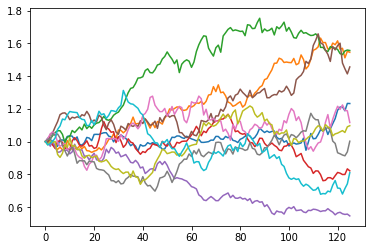

In [ ]:
# Plot several paths

# We need to redeclare h, because `HestonParams` now is a jitted class
h = HestonParams(1, 0.2, 1, 0.2, 0.4, -0.1)
plt.plot(heston_euler(10, h, t, steps));

# Note that the first run of this cell may take much time (several seconds) 
# since Numba needs to compile `heston_euler`. Subsequent runs will be much faster.

In [ ]:
# Compute option price
# Note: this version may be slightly slower than NumPy version 
k = 1.1
%time res = monte_carlo(lambda paths: heston_euler(paths, h, t, steps),\
                        lambda s: np.maximum(s[-1] - k, 0),\
                        control_f = lambda s: s[-1] - 1)
print(res)

CPU times: user 871 ms, sys: 4.88 ms, total: 876 ms
Wall time: 876 ms
MCResult(x=0.08554139828624094, error=0.0009889209517717952, paths=40000, control_var_coef=0.4815662685556683)


## 3.3. Многопоточная версия метода Монте-Карло
Методы Монте-Карло хорошо распараллеливаются на несколько ядер процессора. В Numba для этого достаточно добавить аргумент `parallel=True` в декоратор `@nb.njit` (это автоматически сделает некоторые операции параллельными, например операции с массивами в NumPy и генерацию случайных числе), а также указать какие циклы нужно выполнять параллельно, используя `nb.prange` вместо стандартного `range`.

### 3.3.1. Код

In [ ]:
# The following is the same version as above, with only two changes

@nb.njit(parallel=True)                  # added `parallel=True`
def heston_euler(paths, h, t, steps):
    dt = t/steps
    S = np.empty((steps+1, paths))
    V = np.empty((steps+1, paths))
    S[0] = h.s
    V[0] = h.v
    Z = np.random.randn(2, steps, paths)
    
    for n in nb.prange(paths):           # changed `range` to `nb.prange`
        for i in range(steps):
          v_plus = max(V[i,n], 0)
          V[i+1,n] = V[i,n] + h.kappa*(h.theta-v_plus)*dt + h.sigma*np.sqrt(v_plus) * Z[0,i,n]*np.sqrt(dt)
          S[i+1,n] = S[i,n] * np.exp(
              -0.5*v_plus*dt + np.sqrt(v_plus)*(h.rho*Z[0,i,n] + np.sqrt(1-h.rho**2)*Z[1,i,n])*np.sqrt(dt))
    
    return S

### 3.3.2. Пример

In [ ]:
# Run this cell twice: the first time will be slow, because Numba will recompile `heston_euler`
%time res = monte_carlo(lambda paths: heston_euler(paths, h, t, steps),\
                        lambda s: np.maximum(s[-1] - k, 0),\
                        control_f = lambda s: s[-1] - 1)
print(res)

## 3.4*. Дальнейшие улучшения (функция monte_carlo с использованием Numba)
Команда `%lprun` из пакета `line_profiler` позволяет понять, сколько времени выполняется каждая строка кода. Мы увидим, что в нашем примере с Монте-Карло наиболее трудоемкой является функция `heston_euler`, поэтому, видимо, не будет существенного прироста скорости, если мы перепишем `monte_carlo` с использованием Numba.

In [ ]:
%load_ext line_profiler

In [ ]:
# The following function is copied from Part 2.2 for convenience 
# (and to overwrite the vector-valued version)

def monte_carlo(simulator, f, error=1e-3, conf_level=0.95, max_paths=10000000, 
                batch_size=10000, control_f=None, control_estimation_paths=5000):
    z = st.norm.ppf((1+conf_level)/2)
    x = 0          # estimate of `E(f(X))`
    x_sq = 0       # estimate of `E(f(X)^2)`
    s = 0          # standard error of x
    n = 0          # batches counter (number of paths = n*batch_size)  
    theta = None   # control variate coefficient
    
    if control_f is not None:
        S = simulator(control_estimation_paths)
        c = np.cov(f(S), control_f(S))    # c is the covariance matrix for the two random variables
        theta = c[0, 1] / c[1, 1]
    
    while (n==0 or (z*s/math.sqrt(n*batch_size) > error and n*batch_size < max_paths)):
        S = simulator(batch_size)
        if control_f is not None:
            y = f(S) - theta*control_f(S)
        else:
            y = f(S) 
        x = (x*n + np.mean(y))/(n+1)
        x_sq = (x_sq*n + np.mean(y**2)) / (n+1)
        s = math.sqrt(x_sq - x**2) 
        n += 1
    
    return MCResult(x, z*s/math.sqrt(n*batch_size), n*batch_size, theta)    

%lprun -f monte_carlo res = monte_carlo(lambda paths: heston_euler(paths, h, t, steps),\
                                        lambda s: np.maximum(s[-1] - k, 0),\
                                        control_f = lambda s: s[-1] - 1)

In [ ]:
# monte_carlo rewritten with Numba
# (no significant improvement compared to the previous version)

@jitclass([("x", float64),
           ("error", float64),
           ("paths", int64),
           ("control_var_coef", float64)])            
class MCResult:
    def __init__(self, x, error, paths, control_var_coef):
        self.x = x
        self.error = error    
        self.paths = paths
        self.control_var_coef = control_var_coef
        

@nb.njit
def monte_carlo(simulator, f, error=1e-3, z_cr=1.96, max_paths=10000000, 
                batch_size=10000, control_f=None, control_estimation_paths=5000,
                simulator_args=(), f_args=(), control_f_args=()):
    
    x = 0
    x_sq = 0
    s = 0
    n = 0    
    theta = None
    
    if control_f is not None:
        S = simulator(control_estimation_paths, *simulator_args)
        c = np.cov(f(S, *f_args), control_f(S, *control_f_args))
        theta = c[0, 1] / c[1, 1]
    
    while (n==0 or (z_cr*s/math.sqrt(n*batch_size) > error and n*batch_size < max_paths)):
        S = simulator(batch_size, *simulator_args)
        if theta is not None:
            y = f(S, *f_args) - theta*control_f(S, *control_f_args)
        else:
            y = f(S, *f_args)            
        x = (x*n + np.mean(y))/(n+1)
        x_sq = (x_sq*n + np.mean(y**2)) / (n+1)
        s = math.sqrt(x_sq - x**2)
        n += 1
    
    return MCResult(x, z_cr*s/math.sqrt(n*batch_size), n*batch_size, theta)

# All functions called from jitted code must be jitted as well. Hence we have to 
# rewrite the payoff function anf the control variate.
@nb.njit
def call_payoff(s, k):
    return np.maximum(s[-1] - k, 0)

@nb.njit
def call_control(s):
    return s[-1] - 1 

# Exercise: Why do we need to add to `monte_carlo` arguments `z_cr`, `simulator_args`, `f_args`, `control_f_args`?

In [ ]:
# Run this cell twice
%time res = monte_carlo(simulator=heston_euler,\
                        f=call_payoff,\
                        control_f=call_control,\
                        simulator_args=(h, t, steps),\
                        f_args=(k,))

# We need an explicit print, because `MCResult` is not a dataclass anymore
print(f"x={res.x}, error={res.error}, paths={res.paths}")

## Таблица результатов

Скорость работы всех версий нашего метода Монте-Карло (на моем компьютере).

| Версия | Время (сек.) |
|---------|------------|
|Python   |~45        |
|NumPy    |1.13        |
|NumPy + control variate| 0.427|
|Numba (single thread)  | 0.491| 
|Numba (parallel)       |0.168 |
|Numba (with new monte_carlo) | 0.137|

# 4. Формула Хестона и Numba

## 4.1. Формула Хестона для цены европейского опциона
Приводимая ниже аналитическая формула для цены европейского опциона колл основана на следующих идеях.

1\.  Цену опциона можно представить в виде
$$C = s\tilde\Pi - e^{-rT}K\Pi,$$
где $\tilde\Pi = \tilde P(S_T>K)$ и $\Pi=P(S_T>K)$ являются вероятностями исполнения опциона по мартингальной мере $P$ и по мере $\tilde P$, относительно которой процесс $e^{rt}/S_t$ является мартингалом.

2\. Вероятности исполнения опционов определяются функцией распределения величины $S_T$ или, эквивалентно, величины $X_T = \ln(S_T)$. Функцию распределения $X_T$ можно выразить через обращение ее характеристической функции.

3\. Характеристическую функцию $X_T$ можно найти в явном виде, решив уравнение с частными производными, которое получается из применения формулы Фейнмана-Каца.

**Теорема (S. Heston, 1993).** Цена опциона колл со временем исполнения $T$ и страйком $K$ задается формулой
$$
C = \frac{s-e^{-rT} K}{2} + \frac1\pi \int_0^\infty 
\mathrm{Re}\left( \frac{e^{-iu\ln K} (s \tilde\phi(u) - e^{-rT}K \phi(u))}{iu} \right) du, 
$$
где $\phi(u) = E e^{iu\ln X_T}$ является характеристической функцией лог-цены $X_T = \ln S_T$ относительно мартингальной меры, а
$\tilde\phi(u)$ является такой же функцией относительно меры, для которой $e^{rt}/S_t$ является мартингалом. Эти функции связаны соотношением
$$
\tilde\phi(u) = \frac{\phi(u-i)}{s e^{rT}}.
$$
Функция $\phi(u)$ имеет вид (с $i=\sqrt{-1}$)
$$
\phi(u) = \exp(C(u) + D(u)v + iu \ln s),
$$
где
$$
\begin{aligned}
&C(u) = irT u + \frac{\kappa\theta}{\sigma^2}
  \left(
    (\kappa- i\rho\sigma u - d(u)) T -
    2\ln\left( \frac{1-g(u)e^{-d(u)T}}{1-g(u)} \right)
  \right),\\
&D(u) = \frac{\kappa - i\rho\sigma u - d(u)}{\sigma^2}
  \left( \frac{1-e^{-d(u)T}}{1-g(u)e^{-d(u)T}} \right),
\end{aligned}
$$
и
$$
d(u) = \sqrt{(i\rho\sigma u - \kappa)^2 + \sigma^2(iu + u^2)}, \qquad
g(u) = \frac{i\rho\sigma u- \kappa +d(u)}{i\rho\sigma u - \kappa -d(u)}.
$$


## 4.2. Реализация на Python
### 4.2.1. Код

In [ ]:
import cmath   # math for complex numbers
import scipy.integrate as intg
import scipy.optimize as opt

In [ ]:
# This is the same class as above. It is here for convenience and to overwrite Numba's jitted version.
@dataclass
class HestonParams:    
    s: float
    v: float
    kappa: float
    theta: float
    sigma: float
    rho: float


def heston_cf(h, u, t):
    """Characteristic function of the log-price at time t.
    
    Args:
      h: Parameters of the model (HestonParams).
      u: Argument of the characteristic function (float or complex).
      t: Time.
    """    
    d = cmath.sqrt((h.rho*h.sigma*u*1j - h.kappa)**2 + h.sigma**2*(u*1j + u**2))     # 1j is complex i
    g = ((h.rho*h.sigma*u*1j - h.kappa + d) / (h.rho*h.sigma*u*1j - h.kappa - d))
    C = (h.kappa*h.theta/h.sigma**2 * 
         (t*(h.kappa - h.rho*h.sigma*u*1j - d) - 2*cmath.log((1 - g*cmath.exp(-d*t))/(1-g))))
    D = ((h.kappa - h.rho*h.sigma*u*1j - d)/h.sigma**2 * 
         ((1 - cmath.exp(-d*t)) / (1 - g*cmath.exp(-d*t))))
    return cmath.exp(C + D*h.v + u*math.log(h.s)*1j)


def heston_call_price(h, t, k):
    """Price of a call option in the Heston model.
    
    Args:
      h: Parameters of the model (HestonParams).
      t: Expiration time.
      k: Strike.
    """
    def integrand(u):
        return (cmath.exp(-1j*u*cmath.log(k))/(1j*u) * 
                (heston_cf(h, u-1j, t) - k*heston_cf(h, u, t))).real
    
    return (0.5*(h.s - k) + 1/math.pi * intg.quad(integrand, 0, math.inf)[0])  # see scipy.integrate.quad

### 4.2.2. Пример

In [ ]:
# Compute option price (with the same parameters as we used for Monte-Carlo)
h = HestonParams(s=1, v=0.2, kappa=1, theta=0.2, sigma=0.4, rho=-0.1)
t = 0.5
k = 1.1
print(heston_call_price(h, t, k))

In [ ]:
%timeit -n 100 -r 5 heston_call_price(h, 0.5, 1.1)

## 4.3. Подгонка параметров модели (на Python)
Под подгонкой параметров понимается задача нахождения параметров модели Хестона, которые бы давали кривую (или поверхность) предполагаемой волатильности наиболее близкую к наблюдаемой рыночной кривой. В качестве меры близости мы будем использовать среднеквадратичное отклонение предполагаемых волатильностей.

### 4.3.1. Код


In [ ]:
# Standard normal density and distribution functions.
# We could also use st.norm.pdf and st.norm.cdf, but they are slower for scalar arguments
def phi(x):
    """Standard normal density function."""
    return 1/math.sqrt(2*math.pi)*math.exp(-0.5*x*x)

def Phi(x):
    """Standard normal cumulative distribution function."""
    return (1 + math.erf(x / math.sqrt(2))) / 2   # math.erf is the error function

def impvol(s, t, k, c):
    """Black-Scholes implied volatility of a call option.
    
    Args:
      s: Stock price at time 0.
      t: Expiration time.
      k: Strike.
      c: Call option price.
    
    Returns:
      Implied volatility if it can be computed (Newton's root 
      finding method applied to the Black-Scholes formula 
      successfully converges). Otherwise returns NaN.
      
    Notes:
      Risk-free interest rate is assumed to be 0.
    """
    def equation(sigma):
        d1 = (math.log(s/k) + 0.5*t*sigma**2) / (sigma*math.sqrt(t))
        d2 = d1 - sigma*math.sqrt(t)
        c_bs = s*Phi(d1) - k*Phi(d2)
        return c_bs - c
    
    # Find a good starting value for Newton's method.
    # We use the approximate formula of Corrado and Miller.
    a = max(0, (c - (s-k)/2)**2 - (s-k)**2/math.pi)
    sigma0 = math.sqrt(2*math.pi/t)/(s + k) * (c - (s-k)/2 + math.sqrt(a))
   
    res = opt.newton(equation, sigma0, full_output=True)    # see scipy.optimize.newton for details
    
    return res[0] if res[1].converged else math.nan


def heston_iv(h, t, k):
    """Implied volatility produced by the Heston model."""
    return impvol(h.s, t, k, heston_call_price(h, t, k))


def heston_calibrate(s, t, k, iv):
    """Calibration of the Heston model parameters.
    
    This functions accepts an observed implied volatility curve and find the parameters 
    of the Heston model which minimize the mean square difference between the model 
    and observed implied volatility.
    
    Args:
      s: Stock price at time 0.
      t: Expiration time of options (scalar).
      k: Strikes (array).
      iv: Implied volatility corresponding to the strikes (array).
      
    Returns:
      Parameters of the model as a HestonParams instance.
    """
    def objective(p):
        # p = [v, kappa, theta, sigma, rho]
        return sum((heston_iv(HestonParams(s, *p), t, k[i]) - iv[i])**2 for i in range(len(k)))
    
    v0 = iv[np.abs(k-s).argmin()]**2   # variance of the closest-to-the-money option
    res = opt.minimize(
        fun=objective,
        x0=(v0, 1, v0, 1.0, -0.5),
        method="SLSQP",  # this method works best here, but you can try other methods
        bounds=[(0, math.inf), (0, math.inf), (0, math.inf), (0, math.inf), (-1, 1)])
    return HestonParams(s, *res.x)

### 4.3.2. Пример

Мы построим искусственную кривую предполагаемой волатильности путем добавления шума к кривой волатильности модели Хестона, а затем подгоним параметры модели к этой зашумленной кривой.

In [ ]:
k = np.linspace(0.6,1.35,10)
iv = np.array([heston_iv(h, 0.5, k_) for k_ in k])
iv_noise = iv + np.random.randn(len(k))*0.002

plt.plot(k, iv, label="True IV")
plt.scatter(k, iv_noise, label="True IV + noise")
plt.legend()

In [ ]:
%time h_calibrated = heston_calibrate(1, 0.5, k, iv_noise)
print(h_calibrated)

In [ ]:
# Plot IV curves
iv_calibrated = [heston_iv(h_calibrated, 0.5, k_) for k_ in k] 
plt.plot(k, iv, label="True IV")
plt.scatter(k, iv_noise, label="True IV + noise")
plt.plot(k, iv_calibrated, label="Calibrated IV")
plt.legend()

## 4.4. Использование Numba для быстрого интегрирования
В приведенном выше коде для вычисления цены опциона много времени тратится на вычисление характеристической функции и вычисление подынтегральной функции в формуле Хестона. Далее мы перепишем этот фрагмент на Numba. Для этого потребуется переопределить подынтегральную функцию как C-callable, что позволит `scipy.integrate.quad` вызывать ее непосредственно, минуя механизм вызова Python.

*Замечание.* С-callable - это скомпилированная функция, которая подгружается как библиотека, а интерпретатор Python может вызывать ее непосредственно (подробнее см., например, документацию к пакету `ctypes`). Например, так реализованы почти все функции в пакете NumPy, за счет чего он и является таким быстрым.

In [ ]:
from numba.types import CPointer, float64, intc
from scipy import LowLevelCallable

### 4.4.1. Код

In [ ]:
@jitclass([("s", float64),
           ("v", float64),
           ("kappa", float64),
           ("theta", float64),
           ("sigma", float64),
           ("rho", float64)])
class HestonParams:  
    def __init__(self, s, v, kappa, theta, sigma, rho):
        self.s = s
        self.v = v
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.rho = rho
  

# The following function is the same as above, we only added @nb.jit
@nb.njit
def heston_cf(h, u, t):
    d = cmath.sqrt((h.rho*h.sigma*u*1j - h.kappa)**2 + h.sigma**2*(u*1j + u**2))     # 1j is complex i
    g = ((h.rho*h.sigma*u*1j - h.kappa + d) / (h.rho*h.sigma*u*1j - h.kappa - d))
    C = (h.kappa*h.theta/h.sigma**2 * 
         (t*(h.kappa - h.rho*h.sigma*u*1j - d) - 2*cmath.log((1 - g*cmath.exp(-d*t))/(1-g))))
    D = ((h.kappa - h.rho*h.sigma*u*1j - d)/h.sigma**2 * 
         ((1 - cmath.exp(-d*t)) / (1 - g*cmath.exp(-d*t))))
    return cmath.exp(C + D*h.v + u*math.log(h.s)*1j)


# In the following function, the 2nd argument contains a pointer to an 
# array of parameters, and the 1st argument is the length of the array (we don't need it)
@nb.cfunc(float64(intc, CPointer(float64)))
def heston_call_price_integrand(n, x):  # x = (u, t, k, s, v, kappa, theta, nu, rho):
    u = x[0]
    t = x[1]
    k = x[2]
    s = x[3]
    v = x[4]
    kappa = x[5]
    theta = x[6]
    sigma = x[7]
    rho = x[8]
    h = HestonParams(s, v, kappa, theta, sigma, rho)
    return (cmath.exp(-1j*u*math.log(k))/(1j*u) * 
            (heston_cf(h, u-1j, t) - k*heston_cf(h, u, t))).real

# This is not jitted because Numba does not optimize scipy.integrate.quad
def heston_call_price(h, t, k):   
    return 0.5*(h.s - k) + 1/math.pi * intg.quad(
        LowLevelCallable(heston_call_price_integrand.ctypes), 
        0, math.inf, 
        args=(t, k, h.s, h.v, h.kappa, h.theta, h.sigma, h.rho))[0]

### 4.4.2. Пример

In [ ]:
# (Compare this with section 4.2.2: 1.22 ms there)
h = HestonParams(s=1, v=0.2, kappa=1, theta=0.2, sigma=0.4, rho=-0.1)
%timeit -n 100 -r 5 heston_call_price(h, 0.5, 1.1)

In [ ]:
# Run twice
%time h_calibrated = heston_calibrate(1, 0.5, k, iv_noise)

print(f"v={h_calibrated.v}, kappa={h_calibrated.kappa}, theta={h_calibrated.theta}," ,
      f"sigma={h_calibrated.sigma}, rho={h_calibrated.rho}") # we cannot just print(h_calibrated)

# Note: we may get slightly different parameters values compared to Numpy, 
# but the IV curves will be close (see the next graph)

In [ ]:
# Plot IV curves
iv_calibrated_n = [heston_iv(h_calibrated, 0.5, k_) for k_ in k] 
plt.plot(k, iv, label="True IV")
plt.scatter(k, iv_noise, label="True IV + noise")
plt.plot(k, iv_calibrated, label="Calibrated IV (Numpy)")
plt.plot(k, iv_calibrated_n, linestyle="dashed", label="Calibrated IV (Numba)")
plt.legend()

## 4.5*. Numba для вычисления предполагаемой волатильности
Можно также переписать вычисление предполагаемой волатильности на Numba (она нужна нам для вычисления качества подгонки модели). Для этого потребуется реализовать метод Ньютона нахождения корня уравнения, так как функция `newton` из SciPy не поддерживается Numba.

Мы увидим, что действительно можно значительно ускорить вычисление предполагаемой волатильности, однако это не даст значительного эффекта для процедуры подгонки модели, так как вычисление волатильности в ней не такая трудоемкая процедура по сравнению с вычислением цены опциона.

### 4.5.1. Метод Ньютона

Предположим, что нужно найти решение $x^*$ уравнения 
$$f(x) = 0.$$

*Метод Ньютона* состоит в построении последовательности $x_n$ такой, что при некоторых условиях на $f(x)$ выполнено
$$x_n \to x^*.$$

**Теорема.** Пусть $f(x)$ непрерывно дифференцируема в некоторой окрестности своего корня $x^*$ и $f'(x^*) \neq 0$. Тогда найдется окрестность $B_\varepsilon(x^*)$ такая, что для любого $x_0\in B_\varepsilon(x)$ последовательность
$$ x_{n+1} = x_{n} - \frac{f(x_n)}{f'(x_n)}, \qquad n=0,1,\ldots,$$
имеет предел
$$\lim_{n\to\infty} x_n = x^*.$$


### 4.5.2. Код

In [ ]:
@nb.njit
def phi(x):
    """Standard normal density function."""
    return 1/math.sqrt(2*math.pi)*math.exp(-0.5*x*x)

@nb.njit
def Phi(x):
    """Standard normal cumulative distribution function."""
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

# @vectorize allows to pass array arguments to functions with scalar arguments
# applying NumPy's broadcasting rules
@nb.vectorize
def impvol_new(s, t, k, c):
    eps = 1.48e-08   # same precision as in SciPy's Newton method
    a = max(0.0, (c - (s-k)/2.0)**2.0 - (s-k)**2.0/np.pi)
    sigma = np.sqrt(2.0*np.pi/t)/(s + k) * (c - (s-k)/2.0 + np.sqrt(a))
    
    for n in range(0, 300):  # Maximum 300 iterations in Newton's method. Here, this is enough.
        d1 = (np.log(s/k) + 0.5*t*sigma**2) / (sigma*np.sqrt(t))
        d2 = d1 - sigma*np.sqrt(t)
        c_bs = s*Phi(d1) - k*Phi(d2)
        f = c_bs - c
    
        if abs(f) < eps:
            break
        vega = s * phi(d1) * np.sqrt(t)  # vega is the derivative of the price w.r.t. sigma
        sigma = sigma - f/vega
    
    return sigma if n<300 else np.NaN
 
# Note: here we use Numpy's vectorize (np.vectorize), not Numba's
# because heston_call_price cannot be jitted
@np.vectorize    
def heston_iv(h, t, k):
    return impvol_new(h.s, t, k, heston_call_price(h, t, k))

### 4.5.3. Пример

In [ ]:
# Old implied volatility
%timeit -n 1000 -r 5 impvol(1, 0.5, 1.1, 0.085)

In [ ]:
# New implied volatility
impvol_new(1, 0.5, 1.1, 0.085)   # for compilation
%timeit -n 10000 -r 5 impvol_new(1, 0.5, 1.1, 0.085)

In [ ]:
# Whole calibration procedure with the new implied volatility function
# Run twice
%time h_calibrated = heston_calibrate(1, 0.5, k, iv_noise)

print(f"v={h_calibrated.v}, kappa={h_calibrated.kappa}, theta={h_calibrated.theta}," ,
      f"sigma={h_calibrated.sigma}, rho={h_calibrated.rho}")

iv_calibrated_n2 = [heston_iv(h_calibrated, 0.5, k_) for k_ in k] 
plt.plot(k, iv, label="True IV")
plt.scatter(k, iv_noise, label="True IV + noise")
plt.plot(k, iv_calibrated, label="Calibrated IV (Numpy)")
plt.plot(k, iv_calibrated_n2, linestyle="dashed", label="Calibrated IV (Numba), ver. 2")
plt.legend()

## Таблица результатов

**Цена опциона по формуле Хестона**

| Версия | Время (миллисек.) |
|---------|------------|
|Python (using SciPy)         |1.22   |
|Numba   | 0.073|

**Подгонка параметров модели**  

| Версия | Время (сек.) |
|---------|------------|
|Python (using SciPy)  | 9    |
|Numba                 | 0.355|

**Вычисление предполагаемой волатильности**

| Версия | Время (микросек.) |
|---------|------------|
|Python (using SciPy)  |108   |
|Numba                 | 1.54|

<style>
    ul {list-style-position: inside; padding-left:1em; margin-top:0;}
    p.a {margin-bottom:0; margin-top:0;}
</style>
# 5. Вычисления на GPU
## 5.1. Основные принципы

<p class="a"><b>Отличия CPU от GPU</b></p>

- CPU может выполнять широкий набор инструкций с возможностью параллельного выполнения на небольшом числе ядер. При параллельном выполнении каждое ядро может исполнять различные инструкции.
- GPU выполняет ограниченный набор инструкций, но может исполнять один фрагмент программы параллельно на большом числе ядер.  
- CPU лучше справляется с задачами общего характера, GPU - с задачами, где возможно параллельное исполнение (графика, научные вычисления и т.п.)

**CUDA** (Compute Unified Device Architecture) - это программно-аппаратная архитектура для использования GPU Nvidia в общих вычислительных задачах. Программная часть состоит из компилятора C++ и библиотек для численных методов. В Python поддерживается несколькими пакетами: PyCUDA, Numba, CuPy. Также может использоваться в некоторых пакетах для машинного обучения (TensorFlow, PyTorch, и др.). Мы рассмотрим только CuPy.

<p class="a"><b>Схема работы алгоритма, использующего CUDA</b></p>

- Скопировать данные из основной оперативной памяти в память GPU.
- Запустить фрагмент кода ("ядро") параллельно в несколько потоков на GPU. Потоки будут выполнять одну и ту же последовательность инструкций и использовать одну область памяти.
- Скопировать результат вычислений обратно в основную оперативную память.

Для эффективного использования GPU нужно применять алгоритмы, которые равномерно загружают ядра GPU и минимизируют копирование данных в/из основной памяти. *Детали:* [CUDA C/C++ Basics](https://www.nvidia.com/docs/IO/116711/sc11-cuda-c-basics.pdf).

**Пакет CuPy** является аналогом NumPy для CUDA и реализует большинство функций из NumPy на GPU. Для простых применений обычно достаточно просто заменить в программе `numpy.` на `cupy.` (например, вместо `numpy.random.randn(10000)` использовать `cupy.random.randn(10000)`).


## 5.3. Метод Монте-Карло с использованием CuPy
Здесь мы с небольшими изменениями копируем реализацию метода Монте-Карло с NumPy. Основное изменение - добавлен параметр `toolkit`, в который можно передать значение `toolkit=np` или `toolkit=cp`; соответственно мы заменим `np.` на `toolkit.`

Также в функции `monte_carlo` изменим значение `error` по умолчанию на `1e-4` (т.е. точность станет в 10 раз выше, что приведет к увеличению времени работы примерно в 100 раз), `max_paths` на 10 млн., и увеличим `batch_size` до 250000.

Для удобства все пакеты импортируются еще раз и вспомогательные классы определяются заново; можно запускать ноутбук сразу с этого места, без выполнения предыдущих ячеек.

### 5.3.1. Код

In [ ]:
from dataclasses import dataclass
import math
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

In [ ]:
import cupy as cp

In [ ]:
@dataclass
class HestonParams:
    s: float
    v: float
    kappa: float
    theta: float
    sigma: float
    rho: float
        

@dataclass
class MCResult:
    x: float
    error: float    
    paths: int    
    control_var_coef: float = None
        
        
def monte_carlo(simulator, f, error=1e-4, conf_level=0.95, max_paths=10000000, 
                batch_size=250000, control_f=None, control_estimation_paths=5000,
                toolkit=np):
    z = st.norm.ppf((1+conf_level)/2)
    x = 0          
    x_sq = 0       
    s = 0          
    n = 0          
    theta = None   
    
    if control_f is not None:
        S = simulator(control_estimation_paths)
        c = toolkit.cov(f(S), control_f(S))            
        theta = c[0, 1] / c[1, 1]
    
    while (n==0 or (z*s/math.sqrt(n*batch_size) > error and n*batch_size < max_paths)):
        S = simulator(batch_size)
        if control_f is not None:
            y = f(S) - theta*control_f(S)
        else:
            y = f(S) 
        x = (x*n + toolkit.mean(y))/(n+1)              
        x_sq = (x_sq*n + toolkit.mean(y**2)) / (n+1)   
        s = math.sqrt(x_sq - x**2) 
        n += 1
    
    return MCResult(x, z*s/math.sqrt(n*batch_size), n*batch_size, theta)
     

def heston_euler(paths, h, t, steps, toolkit=np):
    dt = t/steps
    # Below float32 is used to save memory (occupies 4 bytes, while float occupies 8 bytes)
    # Also, GPUs work faster with float32 than with float
    S = toolkit.empty((steps+1, paths), dtype=toolkit.float32)
    V = toolkit.empty((steps+1, paths), dtype=toolkit.float32)
    V[0] = h.v
    S[0] = h.s
    Z = toolkit.random.randn(2, steps, paths)
    
    for i in range(steps):
        v_plus = toolkit.maximum(V[i], 0)
        V[i+1] = V[i] + h.kappa*(h.theta-v_plus)*dt + h.sigma*toolkit.sqrt(v_plus) * Z[0,i]*math.sqrt(dt)
        S[i+1] = S[i] * toolkit.exp(
            -0.5*v_plus*dt + toolkit.sqrt(v_plus)*(h.rho*Z[0,i] + math.sqrt(1-h.rho**2)*Z[1,i])*math.sqrt(dt))
    
    return S

### 5.3.2. Примеры

In [ ]:
# Our usual parameters
h = HestonParams(1, 0.2, 1, 0.2, 0.4, -0.1)
t = 0.5
steps = 125

In [ ]:
# Performance of NumPy version
%time res = monte_carlo(lambda paths: heston_euler(paths, h, t, steps, np), \
                        lambda s: np.maximum(s[-1] - 1.1, 0), \
                        control_f = lambda s: s[-1] - 1, \
                        toolkit = np)                        
print(res)

In [ ]:
# Performance of CuPy version
# You may need to run this cell twice: the first run may be slow because of GPU initialization 
%time res = monte_carlo(lambda paths: heston_euler(paths, h, t, steps, cp), \
                        lambda s: cp.maximum(s[-1] - 1.1, 0), \
                        control_f = lambda s: s[-1] - 1, \
                        toolkit = cp)                        
print(res)

## 5.4. Синтез ядер в CuPy
Ядро в CUDA - это фрагмент кода, который выполняется параллельно на GPU. В приведенной выше реализации функции `heston_euler` ядрами являются вызовы функций CuPy (`cp.empty`, `cp.random.randn` и т.д.). Работу алгоритма можно ускорить, если объединить несколько ядер в одно. Мы сделаем это для функций внутри цикла `for`.

CuPy позволяет задавать ядра несколькими способами; самый простой - использовать декоратор `@cp.fuse`. Декорированная им функция должна содержать только вызовы функций из CuPy, которые будут динамически скомпилированы в новое ядро.

### 5.4.1. Код

In [ ]:
@cp.fuse
def kernel(s, v, z1, z2, kappa, theta, sigma, rho, dt):   # There is no easy way to pass `HestonParams`
    vp = cp.maximum(v, 0)
    sn = s * cp.exp(-0.5*dt*vp + cp.sqrt(vp)*(rho*z1 + cp.sqrt(1-rho**2)*z2)*cp.sqrt(dt))
    vn = v + kappa*(theta-vp)*dt + sigma*cp.sqrt(vp) * z1*cp.sqrt(dt)      
    return sn, vn 
           

def heston_euler_fused(paths, h, t, steps):
    dt = t/steps
    S = cp.empty((steps+1, paths), dtype=cp.float32)
    V = cp.empty((steps+1, paths), dtype=cp.float32)
    S[0] = h.s
    V[0] = h.v
    Z = cp.random.randn(2, steps, paths, dtype=cp.float32)
    
    for i in range(steps):       
        S[i+1], V[i+1] = kernel(S[i], V[i], Z[0,i], Z[1,i], h.kappa, h.theta, h.sigma, h.rho, dt)       
    
    return S

### 5.4.2. Примеры

In [ ]:
# Run twice
%time res = monte_carlo(lambda paths: heston_euler_fused(paths, h, t, steps), \
                        lambda s: cp.maximum(s[-1] - 1.1, 0), \
                        control_f = lambda s: s[-1] - 1, \
                        toolkit = cp)  
print(res)

In [ ]:
# To find out how much time our code spends on CPU and GPU in `heston_euler` function, 
# we can use `cupyx.profiler.benchmark`.
# (`%time` measures only CPU time, but `benchmark` measures both CPU and GPU time)
import cupyx as cpx

In [ ]:
# We can see that kernel fusion greatly reduces CPU time
print(cpx.profiler.benchmark(heston_euler, (250000, h, t, steps, cp), n_repeat=20))
print("-----")
print(cpx.profiler.benchmark(heston_euler_fused, (250000, h, t, steps), n_repeat=20))

## Сравнение результатов

| Версия | Время (сек.) |
|---------|------------|
| Python                         | ~3140       |
|NumPy (с контрольной функцией)  | 31.4       |
|CuPy                            | 0.695 |
|CuPy + kernel fusion            | 0.193 |

(Время для версии на Python основано на оценке из раздела 2, что она примерно в 100 раз медленнее версии Numpy)

<p style="font-size:300%;text-align:center;padding-top:5em">That's all Folks!<br/>😄</p>